In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

# <p style="text-align: center;"> Charter school identities project:<br/> Analyzing Word Embedding Models with word2vec
<p style="text-align: center;">Creator: Jaren Haber, PhD Candidate<br/>Institution: Department of Sociology, University of California, Berkeley<br/>Date created: July 20, 2018

## Initialize Python

In [5]:
# IMPORTING KEY PACKAGES
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector

In [7]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # approximate but effective (and common) method of normalizing words: stems words by implementing a hierarchy of linguistic rules that transform or cut off word endings

In [47]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # For visualizing word embeddings
from scipy.spatial import distance # To use cosine distances for tSNE metric

# Visualization parameters
%pylab inline 
%matplotlib inline
#matplotlib.style.use('white')

import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
#sns.despine()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

In [17]:
# Define data and model file paths
charters_path = "../nowdata/backups/traincf_2015_15_250_counts.pkl" # All text data; only charter schools (regardless if open or not)
wordsent_path = "../nowdata/backups/wem_wordsent_data_train250_nostem.pkl"
phrasesent_path = "../nowdata/backups/wem_phrasesent_data_train250_nostem.pkl"
wem_path = "../nowdata/backups/wem_model_train250_nostem.txt"
wem_newpath = "../nowdata/backups/wem_model_train250_nostem_unlapped_300d.txt"

In [18]:
# For loading functions from files in data_tools directory:
import sys; sys.path.insert(0, "../data_tools/")

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

# ## Create lists of stopwords, punctuation, and unicode characters
#from clean_text import clean_sentence, stopwords_make, punctstr_make, unicode_make
#import clean_text

# ## Create lists of stopwords, punctuation, and unicode characters
#stop_words_list = stopwords_make() # Define old vocab file path if you want to remove first, dirty elements
#unicode_list = unicode_make()
#punctstr = punctstr_make()

print("Sentence cleaning preliminaries complete...")

Sentence cleaning preliminaries complete...


## Define helper functions

In [19]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of terms within one dictionary with all other terms in that same dictionary,
    effectively measuring the coherence of the dictionary.
    ...question for development: does it make sense to compare the average cosine similarity score between all terms 
    in thisdict and the average cosine similarity among the total model vocabulary? (Could that be, by definition, 0?)
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_sim = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.distances(word, other_words=thisdict).sum())/len(thisdict) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dict_avg_sim = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    # For comparison, compute average cosine similarity score of each word with ALL other words in the model vocabulary:
    #for word in thisdict:
    #    all_avg_dist = (wem_model.distances(word).sum())/len(model.vocab) # Default is to compare each word with all words
    #    all_avg_dists += all_avg_dist
    #model_avg_dist = 1 - all_avg_dists/len(model.vocab) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Average cosine similarities by word for this dictionary:       \t" + str(dict_avg_dist))
    #print("Compare to avg. cosine similarities by dict words to ALL words:\t" + str(model_avg_dist))
    
    return dict_avg_sim

In [20]:
def dict_oppose(dict1, dict2, wem_model):
    '''Computes the average cosine similarity score of terms in dict1 with all terms in dict2,
    effectively measuring the opposition/non-coherence between the two dictionaries.
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word in dict1 with all words in dict2.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dicts_avg_dist = 0
    
    # Compute average cosine similarity score of each term in dict1 with all terms in dict2:
    for word in dict1:
        word_avg_dist = (wem_model.distances(word, other_words=dict2).sum())/len(dict2) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dicts_avg_dist = word_avg_dists/len(dict1) # Find average cosine similarity score by subtracting avg. distance from 1
    
    return dicts_avg_dist

In [128]:
def expand_dict(thisdict, coredict, maxlen, wem_model):
    '''TO DO: Create function to implement random additions to core dictionary, 
    in contrast to removing least similar word vectors--as focus_dict() does.'''
    
    #code here
    
    thisdict = list(set(thisdict)) # Remove any duplicates
    
    if len(thisdict) != maxlen: # Quality check
        print("WARNING: Function produced a dictionary of length " + str(len(thisdict)) + \
              ", which is not the specified maximum dict length of " + str(maxlen))
    
    return thisdict

In [21]:
def focus_dict(thisdict, coredict, maxlen, wem_model):
    '''Focus thisdict by removing least similar word vectors until reaching maxlen.
    If any words from coredict get removed, compensate for fact that they will get added back in.
        
    Input: A list of terms, core terms not to remove, desired length, and word2vec model.
    Output: The input list focused down to desired length, and still containing all the core terms.'''

    core_count = 0 # Counts number of coredict terms that were removed
    extend_count = 0 # Counts number of terms removed to offset the coming boost of core terms (that were removed and will be added back in)

    while len(thisdict) > maxlen: # Narrow thisdict down to maxlen
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1

    while extend_count < core_count: # Remove terms until length = maxlen - number of core terms removed (to offset those core terms that will be added back in later in this script)
        badvar = model.doesnt_match(thisdict) # Find least matching term
        thisdict.remove(badvar) # Remove that least focal term, to focus dict
        extend_count += 1 # Keep track of # non-core terms added
        if badvar in coredict: # Keep track of number of core terms removed
            core_count += 1
            
    for term in coredict: # Add back in any missing core terms
        if term not in thisdict and term in list(model.vocab):
            thisdict.append(term)
            
    thisdict = list(set(thisdict)) # Remove any duplicates
    
    if len(thisdict) != maxlen: # Quality check
        print("WARNING: Function produced a dictionary of length " + str(len(thisdict)) + \
              ", which is not the specified maximum dict length of " + str(maxlen))
    
    return thisdict 

In [26]:
def display_closestwords(wem_model, word, plotnumber):
    '''Use tSNE to display a spatial map (i.e., scatterplot) of words vectors close to given word in Word2Vec model.
    Projects each word to a 2D space (a reduction from model size) and plots the position of each word with a label.
    Based on this blog: 
    https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)
    
    Args:
        Word2Vec model
        Input word
        Number of words to plot
    Returns:
        Visualization of relationships between given word and its closest word vectors
    '''
    
    dimensions = 300
    
    arr = np.empty((0,dimensions), dtype='f')
    word_labels = [word]

    # get close words
    close_words = wem_model.similar_by_word(word, plotnumber)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(x_coords, y_coords, alpha=1, color='b')

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)
    plt.xlim(x_coords.min()+10, x_coords.max()+10)
    plt.ylim(y_coords.min()+10, y_coords.max()+10)
    plt.show()

## Create and refine dictionary using WEM

In [22]:
model = gensim.models.KeyedVectors.load_word2vec_format(wem_path) # Load word2vec model

In [23]:
# dictionary of words in model (may not work for old gensim)
print(len(model.vocab))
sorted(list(model.vocab)[:200])

481295


['a',
 'about',
 'academic',
 'academics',
 'academy',
 'activities',
 'admissions',
 'after',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'application',
 'apply',
 'april',
 'are',
 'arts',
 'as',
 'at',
 'athletics',
 'back',
 'be',
 'board',
 'board_of_directors',
 'by',
 'calendar',
 'campus',
 'can',
 'careers',
 'center',
 'charter',
 'child',
 'children',
 'class',
 'classroom',
 'click',
 'college',
 'community',
 'contact',
 'contact_us',
 'content',
 'courses',
 'curriculum',
 'data',
 'day',
 'district',
 'do',
 'donate',
 'dyslexia',
 'each',
 'education',
 'educational',
 'elementary',
 'email',
 'employment',
 'english',
 'enroll',
 'enrollment',
 'events',
 'facebook',
 'faculty',
 'families',
 'family',
 'fax',
 'first',
 'for',
 'form',
 'forms',
 'from',
 'funding',
 'grade',
 'grades',
 'handbook',
 'has',
 'have',
 'help',
 'her',
 'here',
 'high',
 'history',
 'home',
 'homeschool',
 'how',
 'i',
 'idea',
 'if',
 'in',
 'info',
 'information',
 'instruction',
 

### Inspect vectors close to term 'inquiry-based'

In [24]:
model.most_similar("inquiry-based")

[('problem-based', 0.7188608646392822),
 ('inquiry_based', 0.7165826559066772),
 ('integrated_interdisciplinary', 0.7108476161956787),
 ('literacy-based', 0.7067997455596924),
 ('problem-based_learning', 0.705278754234314),
 ('experiential_approach', 0.6990994215011597),
 ('technology-infused', 0.6932752132415771),
 ('student-driven_exploration', 0.6918015480041504),
 ('prbl', 0.6899794340133667),
 ('showcase_of_self-driven', 0.6882768273353577)]

In [25]:
# Find the 30 words closest to the term 'inquiry-based'
inq_words = model.most_similar("inquiry-based", topn=30)
inq_words = [word for word, similarity in inq_words]
inq_words

['problem-based',
 'inquiry_based',
 'integrated_interdisciplinary',
 'literacy-based',
 'problem-based_learning',
 'experiential_approach',
 'technology-infused',
 'student-driven_exploration',
 'prbl',
 'showcase_of_self-driven',
 'hands-on_and_minds-on',
 'qcss_employs',
 'simulations_role-playing',
 'project-centered',
 'hands-on/minds-on',
 'active_inquiry',
 'life-based',
 'problem-centered',
 'long-term_in-depth',
 'using_the_grr',
 'hand-on',
 'cognitively_demanding',
 'discussion-based',
 'in-depth_interdisciplinary',
 'inquiry-based_approach',
 'common-core_aligned',
 'fieldwork_experts',
 'life-enhancing_skills',
 'technology-rich',
 'highly_motivational']

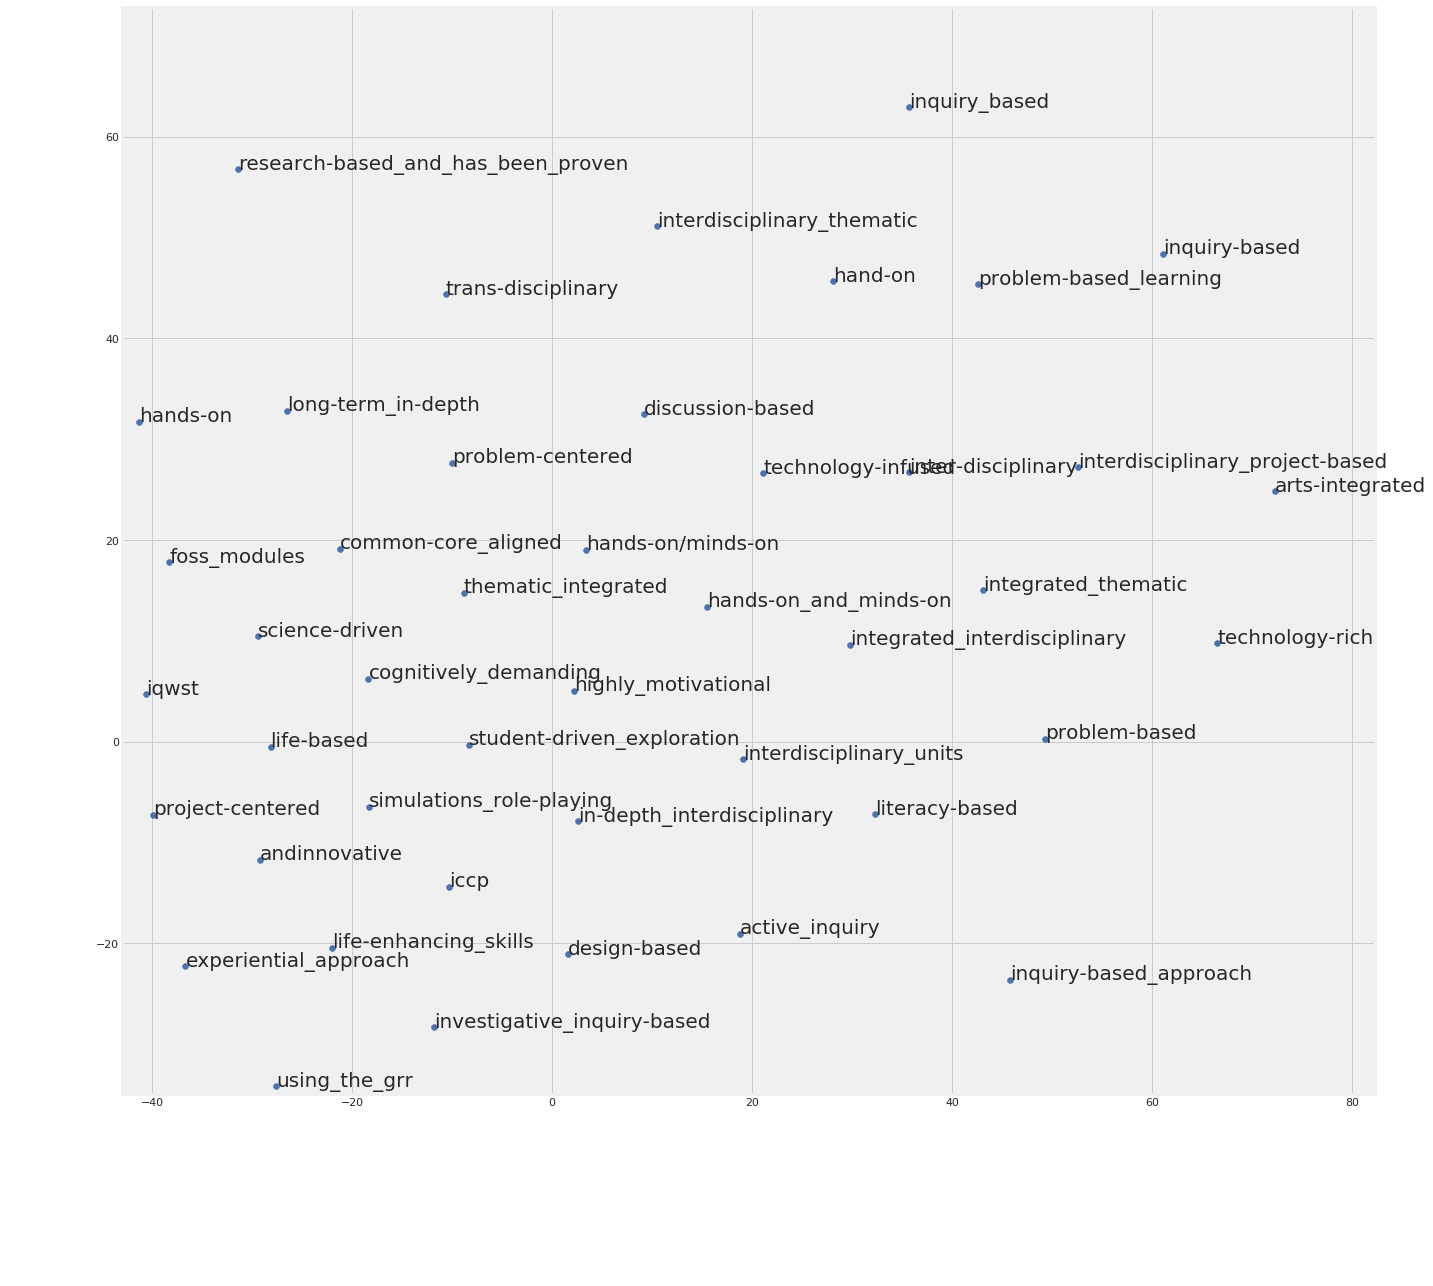

In [27]:
# Display 50 closest words to 'inquiry-based'
display_closestwords(model, "inquiry-based", 50)

### Check integrity of IBL dictionaries of varying lengths

In [129]:
inqseed = ['inquiry-based', 'problem-based', 'discovery', 'experiential', 'constructivist']

# Define 30 core terms:
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

# Load completed dict of 500 terms:
inquiry_fin = [elem.strip('\n') for elem in load_list('data/inquiry.txt')]
inquiry_fin = list(set(inquiry_fin)) # Remove duplicates

sorted(inquiry_fin)

['abilities',
 'abilities_will_be_maximized',
 'ability-grouped',
 'acquire_requisite',
 'active_inquiry',
 'activities',
 'activities/lessons',
 'activity/project',
 'adept_at_facilitating',
 'adherents',
 'adjusted_and_thrived',
 'admittedly_fallible',
 'agile',
 'aligned_to_the_ngss',
 'allegiances',
 'altered/added',
 'amazed_by_the_generosity',
 'anecdotes',
 'appealing_and_relevant',
 'approaches_such_as_sheltered',
 'appropriately_allocated',
 'architecture',
 'arguments_and_informative/explanatory',
 'arithmetic_reasoning',
 'art-filled',
 'artistic',
 'assemble_the_pieces',
 'atomic_nucleus',
 'awaken_the_imagination',
 'bearing_on_the_viability',
 'benefits_of_co-op',
 'bi-literacy',
 'brain-compatible',
 'brain-friendly',
 'break/gross_motor',
 'brighter_tomorrow',
 'brilliantly_infused',
 'brochure_to_solidify',
 'c++_programming',
 'capitalism_and_socialism',
 'career-focused_and_technical',
 'carefully_weigh',
 'case-based',
 'championing_issues',
 'channels_their_energie

In [130]:
# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("NOT FOUND IN CORE DICT, REMOVING:\t" + word)

count = 0
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        #print("NOT FOUND in FULL DICT, REMOVING:\t" + word)

# Loop twice to catch any remaining OOV terms:
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        
print("Removed " + str(count) + " out-of-vocabulary terms from full dictionary.")

Removed 2 out-of-vocabulary terms from full dictionary.


In [131]:
print("Length of original dict: ", len(inq30))
print("Coherence of original dict: ", str(dict_cohere(inq30, model)))

print("Length of extended dict: ", len(inquiry_fin))
print("Coherence of extended dict: ", str(dict_cohere(inquiry_fin, model)))

Length of original dict:  30
Coherence of original dict:  0.694298374917772
Length of extended dict:  498
Coherence of extended dict:  0.5983296162685932


In [132]:
# Use random adds to create a few dicts of different lengths from max length of 500:

print("TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:\n")
# TO DO: Write function expand_dict() above to automate this

inqlist = []; inqlist = inq30 # initialize placeholder for each growing dict
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq30, model)))
print()

# 40 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq30, inquiry_fin) if term in list(model.vocab)], size=10, replace=False))
inq40 = []; inq40 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq40, model)))
print()

# 50 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq40, inquiry_fin) if term in list(model.vocab)], size=10, replace=False))
inq50 = inqlist
#print("50 terms: \n", [term for term in inq50])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq50, model)))
print()

# 75 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq50, inquiry_fin) if term in list(model.vocab)], size=25, replace=False))
inq75 = inqlist
#print("75 terms: \n", [term for term in inq75])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq75, model)))
print()

# 100 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq75, inquiry_fin) if term in list(model.vocab)], size=25, replace=False))
inq100 = inqlist
#print("100 terms: \n", [term for term in inq100])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq100, model)))
print()

# 200 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq100, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq200 = inqlist
#print("200 terms: \n", [term for term in inq200])
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq200, model)))
print()

# 300 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq200, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq300 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq300, model)))
print()

# 400 terms:
inqlist.extend(np.random.choice([term for term in filter(lambda x: x not in inq300, inquiry_fin) if term in list(model.vocab)], size=100, replace=False))
inq400 = inqlist
print(str(len(inqlist)) + "-term dict has this much coherence:", str(dict_cohere(inq400, model)))
print()

print("500-term dict has this much coherence:", str(dict_cohere(inquiry_fin, model)))

TESTING DIFFERENT LENGTHS USING RANDOM ADDITIONS:

30-term dict has this much coherence: 0.694298374917772

40-term dict has this much coherence: 0.6336066746711732

50-term dict has this much coherence: 0.6267515384674072

75-term dict has this much coherence: 0.6087374311659071

100-term dict has this much coherence: 0.6085788740158081

200-term dict has this much coherence: 0.6090105971336366

300-term dict has this much coherence: 0.6010488780551487

400-term dict has this much coherence: 0.6033310662269595

500-term dict has this much coherence: 0.5983296162685932


In [133]:
# TO DO: Fix this

# Use removal of least similar word vectors to create a few dicts of different lengths from max length of 500:
lens_list = [500, 400, 300, 200, 100, 75, 60, 50, 40, 30] # Define desired dict lengths

# Load full 500-term dicts:
inquiry_fin = [elem.strip('\n') for elem in load_list('data/inquiry.txt')]

# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("NOT FOUND IN CORE DICT, REMOVING:\t" + word)
print()

count = 0
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
        #print("NOT FOUND in FULL DICT, REMOVING:\t" + word)
        
for word in inquiry_fin:
    if word not in list(model.vocab):
        inquiry_fin.remove(word)
        count += 1
    
print("Removed " + str(count) + " out-of-vocabulary terms from full dictionary.")

print('TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:\n')

for dictlen in lens_list: 
    inqdict = [],
    
    inqdict = focus_dict(inquiry_fin, inq30, dictlen, model)
    
    print(str(dictlen) + "-term dicts have this much coherence:", str(dict_cohere(inqdict, model)))
    print()


Removed 2 out-of-vocabulary terms from full dictionary.
TESTING DICT LENGTHS BY REMOVING LEAST SIMILAR WORD VECTORS:

500-term dicts have this much coherence: 0.5983296162685932



/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


400-term dicts have this much coherence: 0.6033310662269596



ValueError: cannot select a word from an empty list

## Surprising trends in analyzing how dictionary length affects inter-dictionary opposition and within-dictionary coherence (from this and other analyses):
### Greater lengths make for more within-dictionary coherence, but less across-dictionary opposition.
### Trimming word vectors randomly yields dictionaries that are less coherent and more opposing than does trimming those word vectors least similar to the others in the dictionary.
#### Caveat: The above patterns assume (perhaps consequentially, perhaps not) that as we trim dictionaries, we are keeping a small, core list of concepts (here, 30) intact within each dictionary. The size of this core may influence the above dynamics, as may the relative size of the total dictionary compared to the core list.

## Visualize the core dictionary

In [135]:
# Define terms for dictionary:
inqseed = ['inquiry-based', 'problem-based', 'discovery-based', 'experiential', 'constructivist']
inq30 = ['discovery-based', 'student-driven_exploration', 'exploration_and_experimentation', 'laboratory-based', 
         'problem-based', 'prbl', 'learn-by-doing', 
         'project-based', 'project-centered', 
         'experiential', 'experiential_approach', 'experientially',
         'inquiry-based', 'inquiry-driven', 'student-centered_inquiry-based', 'active_inquiry', 
         'constructivist', 'constructivism', 
         'hands-on', 'hand-on', 'hands-on_learning', 'hands-on_and_minds-on', 'hands-on_minds-on', 'hands-on/minds-on', 
         'socratic', 'socratic_method', 'socratic_dialogue',
         'child-centered', 'learner-centered', 'student-centered']

# Remove any terms from core dict NOT in current model (these will have to be replaced):
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("Removed " + str(word) + " from core dictionary.")
# Repeat for quality:
for word in inq30:
    if word not in list(model.vocab):
        inq30.remove(word)
        print("Removed " + str(word) + " from core dictionary.")

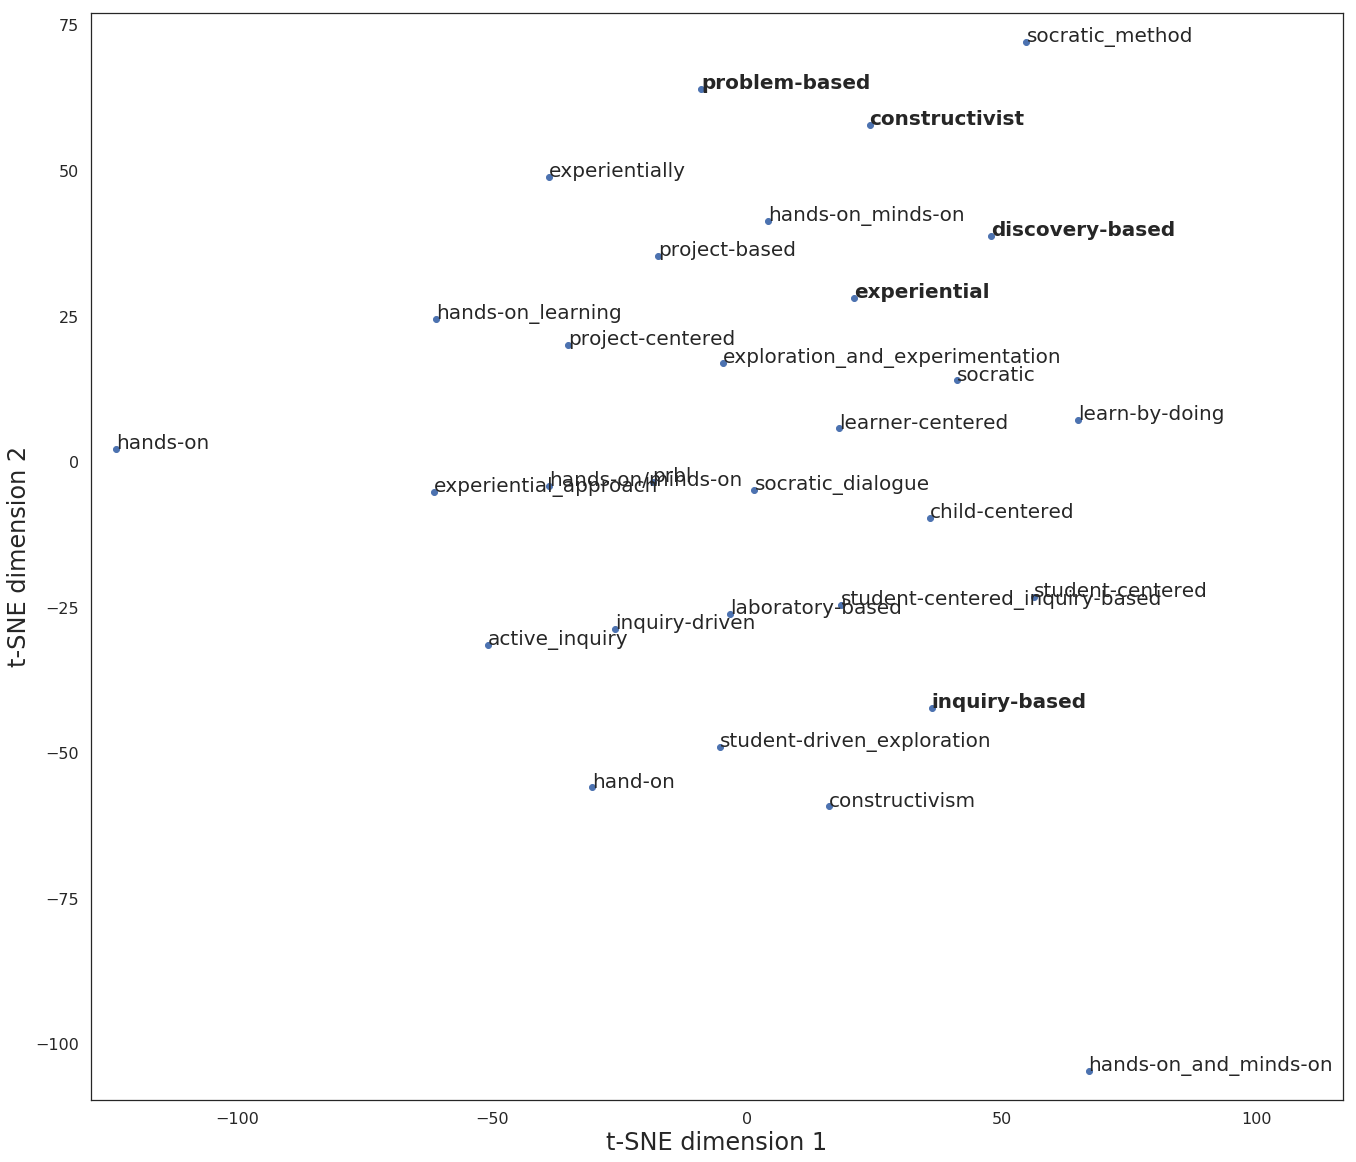

In [140]:
# Set terms for visualization:
core_words = inqseed
close_words = inq30 

# Define model parameters
dimensions = 300
arr = np.empty((0,dimensions), dtype='f')
word_labels = []

# add the vector for each of the closest words to the array
for wrd_label in close_words:
    wrd_vector = model[wrd_label]
    word_labels.append(wrd_label)
    arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
# find tsne coords for 2 dimensions, using cosine distances as metric
tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]

# display scatter plot
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_coords, y_coords, alpha=1, color='b')

sns.set(style='white')
#sns.despine()

for label, x, y in zip(word_labels, x_coords, y_coords):
    if label in core_words:
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontweight='bold').set_fontsize(20)
    else:
        ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)
    
ax.set_xlim(x_coords.min()-5, x_coords.max()+50)
ax.set_ylim(y_coords.min()-5, y_coords.max()+5)
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.xaxis.label.set_fontsize(24)
ax.yaxis.label.set_fontsize(24)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.show()

In [141]:
fig.savefig("data/IBL_core_051519.png", facecolor="white", transparent=True)